# Comparison of EM PPCA with sklearn PCA

In [1]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import time

from sklearn.decomposition import PCA as PCA_sklearn
from sklearn.datasets import load_iris

from scipy.linalg import subspace_angles

# import the EM PPCA
from em_ppca import EMPPCA

np.random.seed(1)

## Complete data case

Let's first look at a comparison in the case when the data is complete (no missing values). From plotting the transformed values of both the sklearn PCA and our implementation of EM PPCA we can observe that they are very similar.

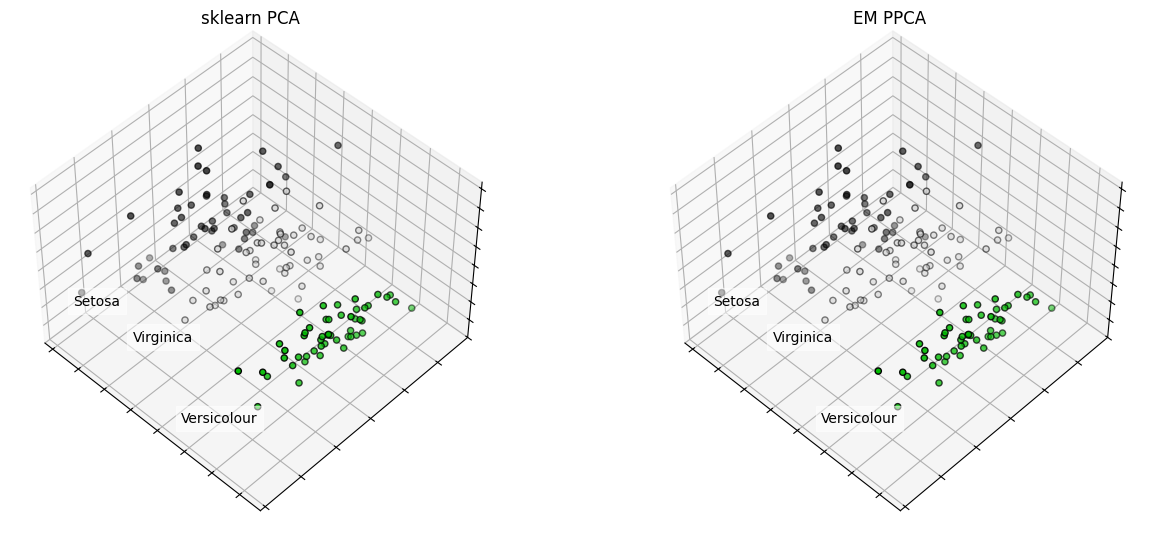

In [2]:
iris = load_iris()
X = iris.data
y = iris.target
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(float)

pca_sklearn = PCA_sklearn(n_components=3)
Z_sklearn = pca_sklearn.fit_transform(X)

em_ppca = EMPPCA(n_components=3)
Z = em_ppca.fit_transform(X)

# Plotting
fig = plt.figure(figsize=plt.figaspect(0.5))

Zs = [Z_sklearn, Z]
titles = ["sklearn PCA", "EM PPCA"]

for i, (data, title) in enumerate(zip(Zs, titles)):
    ax = fig.add_subplot(1, i + 1, i + 1, projection="3d", elev=48, azim=134)
    ax.set_position([i / 1.5, 0, 0.95, 1])

    for name, label in [("Setosa", 0), ("Versicolour", 1), ("Virginica", 2)]:
        ax.text3D(
            data[y == label, 0].mean(),
            data[y == label, 1].mean() + 1.5,
            data[y == label, 2].mean(),
            name,
            horizontalalignment="center",
            bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
        )

    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=y, cmap=plt.cm.nipy_spectral, edgecolor="k")
    ax.set_title(title)

    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])

plt.show()

To quantify the dissimilarity of the principle component subspaces learned by the two implementations, we can compute their angle. Indeed the angle is tiny:

In [3]:
print("Angle between subspaces: {}".format(np.rad2deg(subspace_angles(pca_sklearn.components_.T, em_ppca.components_.T)[0])))

Angle between subspaces: 2.2184842683824304e-12


Finally, we can look at some of the attributes and compare them. They should look almost identical:

In [4]:
print("{0: >30} {1: >40} {2: >40}".format("Attribute", "sklearn PCA", "PPCA"))
strfmt = "{0: >30} {1: >40} {2: >40}"
print(strfmt.format("explained_variance_", np.array2string(pca_sklearn.explained_variance_), np.array2string(em_ppca.explained_variance_)))
print(strfmt.format("explained_variance_ratio_", np.array2string(pca_sklearn.explained_variance_ratio_), np.array2string(em_ppca.explained_variance_ratio_)))
print(strfmt.format("singular_values_", np.array2string(pca_sklearn.singular_values_), np.array2string(em_ppca.singular_values_)))
print(strfmt.format("noise_variance_", np.array2string(pca_sklearn.noise_variance_), np.array2string(em_ppca.noise_variance_)))

                     Attribute                              sklearn PCA                                     PPCA
           explained_variance_       [4.22824171 0.24267075 0.0782095 ]       [4.22822501 0.24267075 0.0782095 ]
     explained_variance_ratio_       [0.92461872 0.05306648 0.01710261]       [0.92461845 0.05306668 0.01710267]
              singular_values_    [25.09996044  6.01314738  3.41368064]    [25.0999109   6.01314738  3.41368064]
               noise_variance_                               0.02383509                               0.02383507


## Missing data case

We now move on to the case when some observations have missing values. Note that sklearn PCA cannot be run with missing values. But we can run it on the complete data to use it as a benchmark.

The first time we run EM PPCA, it takes ~20 seconds to compile. On subsequent runs it's faster due to caching.

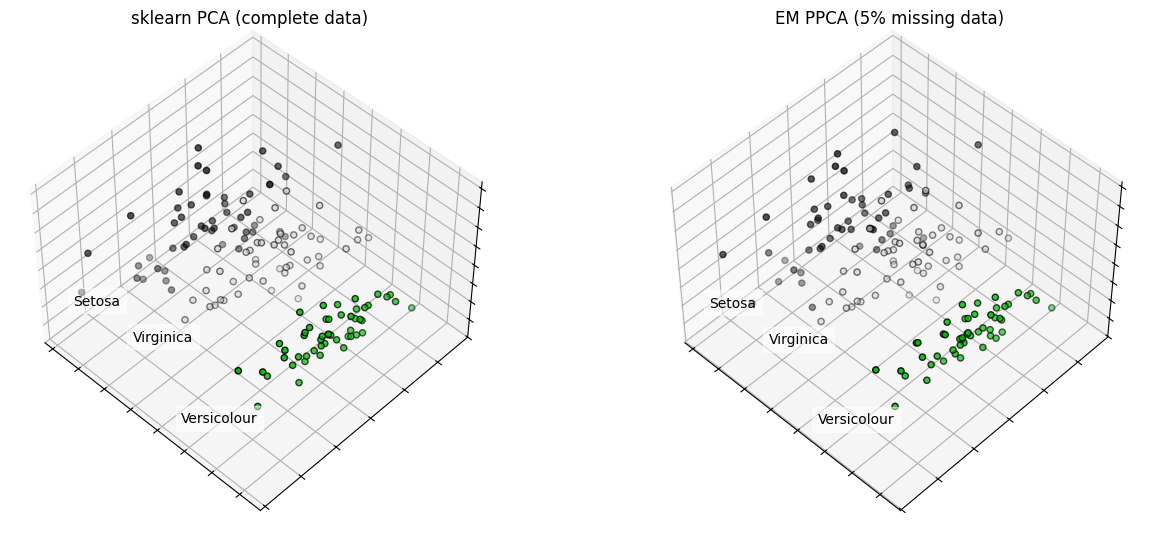

In [5]:
# Remove 5% of the data randomly
missing = np.random.uniform(size=X.shape) < 0.05
X_missing = X.copy()
X_missing[missing] = np.nan

em_ppca = EMPPCA(n_components=3)
Z = em_ppca.fit_transform(X_missing)

# Plotting
fig = plt.figure(figsize=plt.figaspect(0.5))

Zs = [Z_sklearn, Z]
titles = ["sklearn PCA (complete data)", "EM PPCA (5% missing data)"]

for i, (data, title) in enumerate(zip(Zs, titles)):
    ax = fig.add_subplot(1, i + 1, i + 1, projection="3d", elev=48, azim=134)
    ax.set_position([i / 1.5, 0, 0.95, 1])

    for name, label in [("Setosa", 0), ("Versicolour", 1), ("Virginica", 2)]:
        ax.text3D(
            data[y == label, 0].mean(),
            data[y == label, 1].mean() + 1.5,
            data[y == label, 2].mean(),
            name,
            horizontalalignment="center",
            bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
        )

    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=y, cmap=plt.cm.nipy_spectral, edgecolor="k")
    ax.set_title(title)

    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])

plt.show()

Qualitatively, the transformed values look similar at 5% missingness. To get a better idea, we can plot the angle of the subspaces to the complete sklearn PCA as a function of the missingness percentage.

Execution time: 4.851016044616699 seconds


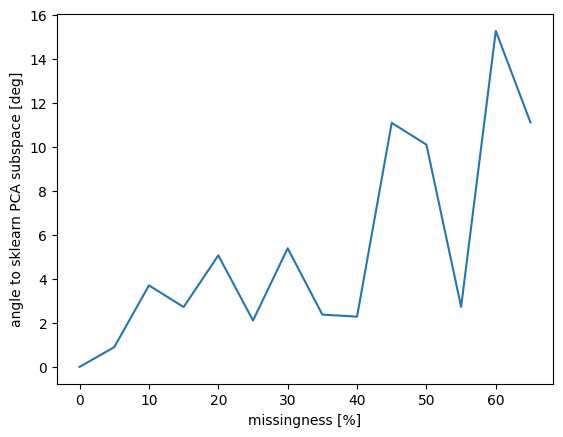

In [6]:
missingness = np.linspace(0, 0.7, 14, endpoint=False)

start_t = time.time()

angles = []
for m in missingness:
    # Remove m% of the data randomly
    missing = np.random.uniform(size=X.shape) < m
    X_missing = X.copy()
    X_missing[missing] = np.nan
    # Remove observations which have all nans...
    all_missing = np.all(np.isnan(X_missing), axis=1)
    X_missing = X_missing[~all_missing, :]

    em_ppca = EMPPCA(n_components=3)
    Z = em_ppca.fit_transform(X_missing)
    angles.append(np.rad2deg(subspace_angles(pca_sklearn.components_.T, em_ppca.components_.T)[0]))

end_t = time.time()

print("Execution time: {} seconds".format(end_t - start_t))

plt.figure()
plt.plot(missingness * 100, angles)
plt.xlabel("missingness [%]")
plt.ylabel("angle to sklearn PCA subspace [deg]")
plt.show()

Note that the previous run took on average much less than 1 second per PPCA model fit.

We can also use the PPCA model to reconstruct some data (here from 5% missingness) and compare it to the original dataset:

In [7]:
# Remove 5% of the data randomly
missing = np.random.uniform(size=X.shape) < 0.1
X_missing = X.copy()
X_missing[missing] = np.nan

em_ppca = EMPPCA(n_components=3)
Z = em_ppca.fit_transform(X_missing)

X_hat = Z @ em_ppca.components_ + em_ppca.mean_[np.newaxis, :]

In [8]:
print("Reconstruction from 5% missingness, using 3 components:")
print(X_hat[:12, :])
print("Original:")
print(X[:12, :])

Reconstruction from 5% missingness, using 3 components:
[[-0.73163926  0.4310041  -2.31031627 -0.97352019]
 [-0.97543979 -0.02530456 -2.31178141 -1.0702181 ]
 [-1.09989606  0.15207696 -2.44441402 -1.02015861]
 [-1.21462751  0.01403489 -2.29929994 -0.93596365]
 [-0.81967925  0.51907402 -2.39202977 -0.94711637]
 [-0.42754927  0.83197218 -2.07342217 -0.77566295]
 [-0.95388358  0.35501221 -2.34017966 -0.926655  ]
 [-0.82589689  0.32527604 -2.283082   -0.9608428 ]
 [-1.42062341 -0.0899474  -2.39067026 -0.9492009 ]
 [-0.92349007  0.02287523 -2.28654561 -1.05552929]
 [-0.43716626  0.6365172  -2.26686407 -0.98572194]
 [-1.03460287  0.33396053 -2.46360483 -0.9800632 ]]
Original:
[[-0.74333333  0.44266667 -2.358      -0.99933333]
 [-0.94333333 -0.05733333 -2.358      -0.99933333]
 [-1.14333333  0.14266667 -2.458      -0.99933333]
 [-1.24333333  0.04266667 -2.258      -0.99933333]
 [-0.84333333  0.54266667 -2.358      -0.99933333]
 [-0.44333333  0.84266667 -2.058      -0.79933333]
 [-1.24333333  